In [1]:
# Import the neccessary libraries
# I've changed the layout of the Excel sheet this references since updating this notebook, 
# so it probably doesn't run currently. I'll fix it evnentually

import pandas as pd
import re
import numpy as np
import warnings
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

# Change a few settings to be more to my liking
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
warnings.filterwarnings("ignore")
def no_sci_format(x):
    if abs(x) < 1e-10:
        return '0'
    else:
        return '{:.12g}'.format(x)
pd.set_option('display.float_format', no_sci_format)

In [2]:
# Download the current edition of my excel file from OneDrive
url = "https://onedrive.live.com/download?resid=936C0322EB2B7176%21296137&authkey=%21ABzwa69qIUoj5wI&em=2&wd"
movie = pd.read_excel(url)

In [3]:
# Get a look at the dataset
movie.head().round(1)

,Film Title,My Rating,Genre,Director,Writer,Producer,Protagonist,Starring,Cinematographer,Editor,Composer,Production Company,Distributor,Country of Origin,Release Date,Runtime,Real Budget,Real Box Office,Real Profit,Inflated Budget,Inflated Box Office,Inflated Profit,ROI,True ROI,Franchise,Place in Continuity,Rating,Oscar Achievements,Release Type,Inspired By A,RT Top Critics Rating,RT Top Critics Score,RT All Critics Rating,RT All Critics Score,RT Verified Audience Rating,RT Verified Audience Score,RT All Audience Rating,RT All Audience Score,MC Critics Score,MC User Score,IMDB Rating,Letterboxd Rating,CinemaScore,Was I Watching?,Watch Date,Movie Age,Movie Age At Watch,Amount of Rewatches,Rank,Statistics
0,Whiplash,10,"Drama, Psychological, Music",Damien Chazelle,Damien Chazelle,"Jason Blum, Helen Estabrook, Michel Litvak, Da...",Miles Teller,"Miles Teller, J. K. Simmons, Paul Reiser",Sharone Meir,Tom Cross,Justin Hurwitz,"Bold Films, Blumhouse Productions, Right of Wa...",Sony Pictures Classics,United States,2014-10-10,106,3300000,49000000,45700000,4244598.6,63025857.9,58781259.3,14.8,5.9,Solo Film,1st,Restricted,"Best Picture Nominee, Best Supporting Actor No...",Theatrical Release,Real Event,94,8.4,94,8.6,NaN,NaN,94,4.5,89,8.8,8.5,4.4,NaN,Yes,2024-04-05,3604 Days,3465 Days,0,98.8,Watched a Movie on
1,Memento,10,"Drama, Mystery, Thriller, Neo-noir, Psychologi...",Christopher Nolan,Christopher Nolan,"Suzanne Todd, Jennifer Todd",Guy Pearce,"Guy Pearce, Carrie-Anne Moss, Joe Pantoliano",Wally Pfister,Dody Dorn,David Julyan,"Summit Entertainment, Team Todd",Newmarket,United States,2001-03-16,113,5000000,40100000,35100000,8598456.3,68959619.7,60361163.4,8,3.2,Solo Film,1st,Restricted,Best Original Screenplay Nominee,Theatrical Release,Short Story,88,7.6,94,8.3,NaN,NaN,94,4.4,83,8.9,8.4,4.2,NaN,Yes,2024-02-14,8560 Days,8370 Days,0,98.8,51.14% of days
2,The Shawshank Redemption,10,"Drama, Prison, Steven King",Frank Darabont,Frank Darabont,Niki Marvin,Tim Robbins,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Roger Deakins,Richard Francis-Bruce,Thomas Newman,Castle Rock Entertainment,Columbia Pictures,United States,1994-09-23,142,25000000,73300000,48300000,51357733.2,150580873.7,99223140.5,2.9,1.2,Solo Film,1st,Restricted,"Best Picture Nominee, Best Actor Nominee, Best...",Theatrical Release,Book,83,8,89,8.2,NaN,NaN,98,4.7,82,9,9.3,4.5,A,Yes,2023-12-15,10926 Days,10675 Days,0,98.8,Average Movie Score
3,12 Angry Men,9.9,"Courtroom, Drama",Sidney Lumet,Reginald Rose,"Henry Fonda, Reginald Rose",Henry Fonda,"Henry Fonda, Lee J. Cobb, Ed Begley, E. G. Mar...",Boris Kaufman,Carl Lerner,Kenyon Hopkins,Orion-Nova Productions,United Artists,United States,1957-04-10,96,337000,2000000,1663000,3652916,21679027,18026110.9,5.9,2.4,Solo Film,1st,Not Rated,"Best Picture Nominee, Best Actor Nominee, Best...",Theatrical Release,Real Event,100,9.1,100,9.1,NaN,NaN,97,4.6,97,8.6,9,4.6,NaN,Yes,2024-08-21,24606 Days,24605 Days,0,98.2,6.976
4,Hereditary,9.8,"Horror, Psychological, Drama, Supernatural",Ari Aster,Ari Aster,"Kevin Frakes, Lars Knudsen, Buddy Patrick",Toni Collette,"Toni Collette, Alex Wolff, Milly Shapiro, Ann ...",Pawel Pogorzelski,"Jennifer Lame, Lucian Johnston",Colin Stetson,"A24, PalmStar Media, Finch Entertainment, Wind...",A24,United States,2018-06-08,127,10000000,82800000,72800000,12126312.8,100405869.7,88279557,8.3,3.3,Solo Film,1st,Restricted,NaN,Theatrical Release,Legend,91,8.4,90,8.3,NaN,NaN,71,3.6,87,6.7,7.3,4,D+,Yes,2023-10-19,2267 Days,1959 Days,0,97.6,Median Movie Score


In [4]:
# Check which columns are currently in the dataset
movie.columns.values.tolist()

['Film Title',
 'My Rating',
 'Genre',
 'Director',
 'Writer',
 'Producer',
 'Protagonist',
 'Starring',
 'Cinematographer',
 'Editor',
 'Composer',
 'Production Company',
 'Distributor',
 'Country of Origin',
 'Release Date',
 'Runtime',
 'Real Budget',
 'Real Box Office',
 'Real Profit',
 'Inflated Budget',
 'Inflated Box Office',
 'Inflated Profit',
 'ROI',
 'True ROI',
 'Franchise',
 'Place in Continuity',
 'Rating',
 'Oscar Achievements',
 'Release Type',
 'Inspired By A',
 'RT Top Critics Rating',
 'RT Top Critics Score',
 'RT All Critics Rating',
 'RT All Critics Score',
 'RT Verified Audience Rating',
 'RT Verified Audience Score',
 'RT All Audience Rating',
 'RT All Audience Score',
 'MC Critics Score',
 'MC User Score',
 'IMDB Rating',
 'Letterboxd Rating',
 'CinemaScore',
 'Was I Watching?',
 'Watch Date',
 'Movie Age',
 'Movie Age At Watch',
 'Amount of Rewatches',
 'Rank',
 'Statistics']

In [5]:
# Sort the dataset by rank
movie.sort_values('Rank', ascending=True, inplace=True)

# List of columns to process
columns_to_process = [
    'Real Budget',
    'Real Box Office',
    'Real Profit',
    'Inflated Budget',
    'Inflated Box Office',
    'Inflated Profit',
    'ROI',
    'True ROI',
    'RT Top Critics Rating',
    'RT Top Critics Score',
    'RT All Critics Rating',
    'RT All Critics Score',
    'RT All Audience Rating',
    'RT All Audience Score',
    'MC Critics Score',
    'MC User Score',
    'IMDB Rating',
    'Letterboxd Rating',
]

# Function to assign values for null entries based on nearby ranks
def assign_value(row, column, nearby_count=7):
    value = row[column]
    if pd.isnull(value):
        rank = int(row['Rank'])
        nearby_ranks = range(max(0, rank - nearby_count), min(len(movie), rank + nearby_count + 1))
        nearby_values = movie.iloc[list(nearby_ranks)][column]
        assigned_value = nearby_values.mean()
        return assigned_value
    else:
        return value

# Apply the function for each column
for column in columns_to_process:
    movie[column] = movie.apply(lambda row: assign_value(row, column), axis=1)
    
# Sort the model by 'Rank'
movie = movie.sort_values(by='Rank', ascending=False)

In [6]:
# Generate a new Boolean column named 'Target' indicating whether each value exceeds a certain percentage threshold
movie['Target'] = movie['Rank'].apply(lambda x: 'Yes' if x > 70 else 'No')

In [7]:
# Drop unneccessary columns, and columns with many many nulls
movie.drop(columns=['True ROI', 'Rank', 'Statistics', 'Film Title', 'RT Verified Audience Rating', 'RT Verified Audience Score', 'CinemaScore'], inplace=True)

In [8]:
# Remove the appended 'Days' from 'Movie Age' and 'Movie Age At Watch', so that they can become integers
movie['Movie Age'] = movie['Movie Age'].str.rstrip(' Days').astype(int)
movie['Movie Age At Watch'] = movie['Movie Age At Watch'].str.rstrip(' Days').astype(int)

In [9]:
date_columns_to_process = ['Release Date', 'Watch Date']

for column in date_columns_to_process:
    # Convert the column to datetime format
    movie[column] = pd.to_datetime(movie[column]) 
    
    # Extract day, month, and year from the date column
    column_name_without_date = column.replace(' Date', '')  # Remove "Date" from the column name
    movie[f'{column_name_without_date} Day of Week'] = movie[column].dt.dayofweek
    movie[f'{column_name_without_date} Day'] = movie[column].dt.day
    movie[f'{column_name_without_date} Month'] = movie[column].dt.month
    movie[f'{column_name_without_date} Year'] = movie[column].dt.year

    # Extract day of the week from the date column and assign to a new column
    movie[f'{column_name_without_date} Day of Week'] = movie[f'{column_name_without_date} Day of Week'].map({
        0: 'Monday',
        1: 'Tuesday',
        2: 'Wednesday',
        3: 'Thursday',
        4: 'Friday',
        5: 'Saturday',
        6: 'Sunday'
    })

    # Map numeric month values to month names
    movie[f'{column_name_without_date} Month'] = movie[f'{column_name_without_date} Month'].map({
        1: 'January',
        2: 'February',
        3: 'March',
        4: 'April',
        5: 'May',
        6: 'June',
        7: 'July',
        8: 'August',
        9: 'September',
        10: 'October',
        11: 'November',
        12: 'December'
    })

    # Drop the original date column
    movie.drop(columns=[column], inplace=True)

In [10]:
movie.head()

,My Rating,Genre,Director,Writer,Producer,Protagonist,Starring,Cinematographer,Editor,Composer,Production Company,Distributor,Country of Origin,Runtime,Real Budget,Real Box Office,Real Profit,Inflated Budget,Inflated Box Office,Inflated Profit,ROI,Franchise,Place in Continuity,Rating,Oscar Achievements,Release Type,Inspired By A,RT Top Critics Rating,RT Top Critics Score,RT All Critics Rating,RT All Critics Score,RT All Audience Rating,RT All Audience Score,MC Critics Score,MC User Score,IMDB Rating,Letterboxd Rating,Was I Watching?,Movie Age,Movie Age At Watch,Amount of Rewatches,Target,Release Day of Week,Release Day,Release Month,Release Year,Watch Day of Week,Watch Day,Watch Month,Watch Year
0,10,"Drama, Psychological, Music",Damien Chazelle,Damien Chazelle,"Jason Blum, Helen Estabrook, Michel Litvak, Da...",Miles Teller,"Miles Teller, J. K. Simmons, Paul Reiser",Sharone Meir,Tom Cross,Justin Hurwitz,"Bold Films, Blumhouse Productions, Right of Wa...",Sony Pictures Classics,United States,106,3300000,49000000,45700000,4244598.59323,63025857.8995,58781259.3062,14.8484848485,Solo Film,1st,Restricted,"Best Picture Nominee, Best Supporting Actor No...",Theatrical Release,Real Event,94,8.4,94,8.6,94,4.5,89,8.8,8.5,4.4,Yes,3604,3465,0,Yes,Friday,10,October,2014,Friday,5,April,2024
1,10,"Drama, Mystery, Thriller, Neo-noir, Psychologi...",Christopher Nolan,Christopher Nolan,"Suzanne Todd, Jennifer Todd",Guy Pearce,"Guy Pearce, Carrie-Anne Moss, Joe Pantoliano",Wally Pfister,Dody Dorn,David Julyan,"Summit Entertainment, Team Todd",Newmarket,United States,113,5000000,40100000,35100000,8598456.3253,68959619.7289,60361163.4036,8.02,Solo Film,1st,Restricted,Best Original Screenplay Nominee,Theatrical Release,Short Story,88,7.6,94,8.3,94,4.4,83,8.9,8.4,4.2,Yes,8560,8370,0,Yes,Friday,16,March,2001,Wednesday,14,February,2024
2,10,"Drama, Prison, Steven King",Frank Darabont,Frank Darabont,Niki Marvin,Tim Robbins,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Roger Deakins,Richard Francis-Bruce,Thomas Newman,Castle Rock Entertainment,Columbia Pictures,United States,142,25000000,73300000,48300000,51357733.1759,150580873.672,99223140.4959,2.932,Solo Film,1st,Restricted,"Best Picture Nominee, Best Actor Nominee, Best...",Theatrical Release,Book,83,8,89,8.2,98,4.7,82,9,9.3,4.5,Yes,10926,10675,0,Yes,Friday,23,September,1994,Friday,15,December,2023
3,9.9,"Courtroom, Drama",Sidney Lumet,Reginald Rose,"Henry Fonda, Reginald Rose",Henry Fonda,"Henry Fonda, Lee J. Cobb, Ed Begley, E. G. Mar...",Boris Kaufman,Carl Lerner,Kenyon Hopkins,Orion-Nova Productions,United Artists,United States,96,337000,2000000,1663000,3652916.04865,21679026.995,18026110.9463,5.93471810089,Solo Film,1st,Not Rated,"Best Picture Nominee, Best Actor Nominee, Best...",Theatrical Release,Real Event,100,9.1,100,9.1,97,4.6,97,8.6,9,4.6,Yes,24606,24605,0,Yes,Wednesday,10,April,1957,Wednesday,21,August,2024
4,9.8,"Horror, Psychological, Drama, Supernatural",Ari Aster,Ari Aster,"Kevin Frakes, Lars Knudsen, Buddy Patrick",Toni Collette,"Toni Collette, Alex Wolff, Milly Shapiro, Ann ...",Pawel Pogorzelski,"Jennifer Lame, Lucian Johnston",Colin Stetson,"A24, PalmStar Media, Finch Entertainment, Wind...",A24,United States,127,10000000,82800000,72800000,12126312.7713,100405869.746,88279556.9748,8.28,Solo Film,1st,Restricted,NaN,Theatrical Release,Legend,91,8.4,90,8.3,71,3.6,87,6.7,7.3,4,Yes,2267,1959,0,Yes,Friday,8,June,2018,Thursday,19,October,2023


In [11]:
# Change categorical values to Strings
movie['Watch Day'] = movie['Watch Day'].apply(lambda x: str(x))
movie['Watch Year'] = movie['Watch Year'].apply(lambda x: str(x))
movie['Release Day'] = movie['Release Day'].apply(lambda x: str(x))
movie['Release Year'] = movie['Release Year'].apply(lambda x: str(x))

In [12]:
# Check for how many times each movie has won an Oscar by searching the String for 'Winner'
def count_winners(row):
    if isinstance(row['Oscar Achievements'], str):
        return row['Oscar Achievements'].count('Winner')
    else:
        return 0

# Apply the 'count_winners' function to 'Oscar Wins'
movie['Oscar Wins'] = movie.apply(count_winners, axis=1)

# Check for how many times each movie has been nominated for an Oscar by searching the String for 'Nominee'
def count_nominees(row):
    if isinstance(row['Oscar Achievements'], str):
        return row['Oscar Achievements'].count('Nominee')
    else:
        return 0

# Apply the 'count_winners' function to 'Oscar Nominations'
movie['Oscar Nominations'] = movie.apply(count_nominees, axis=1)

In [13]:
# Ensure that all columns types are correct
movie.dtypes

My Rating                 float64
Genre                      object
Director                   object
Writer                     object
Producer                   object
Protagonist                object
Starring                   object
Cinematographer            object
Editor                     object
Composer                   object
Production Company         object
Distributor                object
Country of Origin          object
Runtime                     int64
Real Budget               float64
Real Box Office           float64
Real Profit               float64
Inflated Budget           float64
Inflated Box Office       float64
Inflated Profit           float64
ROI                       float64
Franchise                  object
Place in Continuity        object
Rating                     object
Oscar Achievements         object
Release Type               object
Inspired By A              object
RT Top Critics Rating     float64
RT Top Critics Score      float64
RT All Critics

In [14]:
# Make sure that all the data looks correct
movie.head().round(1).T

,0,1,2,3,4
My Rating,10,10,10,9.9,9.8
Genre,"Drama, Psychological, Music","Drama, Mystery, Thriller, Neo-noir, Psychologi...","Drama, Prison, Steven King","Courtroom, Drama","Horror, Psychological, Drama, Supernatural"
Director,Damien Chazelle,Christopher Nolan,Frank Darabont,Sidney Lumet,Ari Aster
Writer,Damien Chazelle,Christopher Nolan,Frank Darabont,Reginald Rose,Ari Aster
Producer,"Jason Blum, Helen Estabrook, Michel Litvak, Da...","Suzanne Todd, Jennifer Todd",Niki Marvin,"Henry Fonda, Reginald Rose","Kevin Frakes, Lars Knudsen, Buddy Patrick"
Protagonist,Miles Teller,Guy Pearce,Tim Robbins,Henry Fonda,Toni Collette
Starring,"Miles Teller, J. K. Simmons, Paul Reiser","Guy Pearce, Carrie-Anne Moss, Joe Pantoliano","Tim Robbins, Morgan Freeman, Bob Gunton, Willi...","Henry Fonda, Lee J. Cobb, Ed Begley, E. G. Mar...","Toni Collette, Alex Wolff, Milly Shapiro, Ann ..."
Cinematographer,Sharone Meir,Wally Pfister,Roger Deakins,Boris Kaufman,Pawel Pogorzelski
Editor,Tom Cross,Dody Dorn,Richard Francis-Bruce,Carl Lerner,"Jennifer Lame, Lucian Johnston"
Composer,Justin Hurwitz,David Julyan,Thomas Newman,Kenyon Hopkins,Colin Stetson


In [15]:
# Replace null values in 'Oscar Achievements' with the String 'None'
movie['Oscar Achievements'].fillna('None', inplace=True)

# List of columns to be processed
columns_to_process = [
    'Starring', 'Director', 'Writer', 'Producer', 'Cinematographer', 
    'Editor', 'Composer', 'Distributor', 'Genre', 'Production Company', 
    'Oscar Achievements', 'Was I Watching?', 'Franchise', 'Country of Origin', 
    'Place in Continuity', 'Release Type'
]

# Loop through each column, split, one-hot encode, and concatenate
for column in columns_to_process:
    data = movie[column].str.split(', ', expand=True)
    dummies = pd.get_dummies(data.stack()).groupby(level=0).sum()
    movie = pd.concat([movie, dummies.add_prefix(f'{column} ')], axis=1)

# Drop original categorical columns
movie = movie.drop(columns=columns_to_process)

In [16]:
# Ensure that there are no nulls in the dataset
null_counts = movie.isnull().sum().sort_values(ascending=False)
null_counts.head()

My Rating                 0
Editor Colin Cairnes      0
Editor Craig McKay        0
Editor Curtiss Clayton    0
Editor Damien Leone       0
dtype: int64

In [17]:
# Remove the column 'My Rating', which will have multicollinearity with 'Rank'
movie2 = movie.drop(columns=['My Rating'])

# Convert all other categorical columns to boolean using one-hot encoding
movie2 = pd.get_dummies(movie2)

# Separate Floats from Booleans
columns_to_round = ['ROI', 'Letterboxd Rating', 'IMDB Rating', 'MC User Score']

# Round the specified columns to 1 decimal place
movie2[columns_to_round] = movie2[columns_to_round].round(1)

# Convert all other columns to integers
movie2.loc[:, ~movie2.columns.isin(columns_to_round)] = movie2.loc[:, ~movie2.columns.isin(columns_to_round)].astype(int)

# Iterate through all column names
for column in movie2.columns:
    # Replace underscores with spaces in the column name for consistency
    new_column_name = column.replace('_', ' ')
    
    # Rename the column with the new name
    movie2.rename(columns={column: new_column_name}, inplace=True)


In [18]:
# Drop any rows with null values from movie2
movie2.dropna(inplace=True)

In [19]:
# Get a look at the new shape of the dataset
movie2.shape

(173, 2979)

In [20]:
# Drop boolean values that have less than x number of instances
movie2.drop([col for col, val in movie2.sum().items() if val < 7], axis=1, inplace=True)

In [21]:
# Compute the correlation each column has with the target, rounded to 6 decimal places
correlation = movie2.drop(['Target No'], axis=1).corr()['Target Yes'].round(6)
correlation = correlation.drop('Target Yes')

num_rows, num_columns = movie2.shape
print(f"Currently, {num_rows} movies are being analyzed, based on {num_columns} datapoints.")
print()
print(correlation)

Currently, 173 movies are being analyzed, based on 153 datapoints.

Runtime                                                0.279022
Real Budget                                            0.159583
Real Box Office                                        0.160831
Real Profit                                            0.138628
Inflated Budget                                        0.216206
Inflated Box Office                                     0.19993
Inflated Profit                                        0.172374
ROI                                                   -0.075161
RT Top Critics Rating                                  0.380649
RT Top Critics Score                                   0.361551
RT All Critics Rating                                  0.387589
RT All Critics Score                                   0.403927
RT All Audience Rating                                 0.442645
RT All Audience Score                                  0.312501
MC Critics Score                    

In [22]:
# Extract feature columns by dropping the 'Target_No' and 'Target_Yes' columns from movie2
feature_cols = movie2.drop(['Target No', 'Target Yes'], axis=1).columns.tolist()

In [23]:
# Extract features (independent variables) from movie2
x = movie2[feature_cols]

# Extract target variable (dependent variable) from movie2
y = movie2['Target Yes']

In [24]:
# Define function to train the Random Forest model
def train_random_forest_model():
    # Instantiate the RandomForestRegressor
    rf_model = RandomForestRegressor()

    # Train the model
    rf_model.fit(x, y)

    # Print feature importances
    print("Feature Importances:")
    feature_importances = rf_model.feature_importances_
    for feature, importance in zip(feature_cols, feature_importances):
        # Check if importance is not equal to 0
        if importance != 0:
            # Limit importance values to 6 decimal places
            importance = round(importance, 6)
            print(f"{feature}: {importance}")

    # Predict on the test set
    predictions = rf_model.predict(x)

    # Calculate and print performance metrics
    print("\nPerformance Metrics:")
    mae = metrics.mean_absolute_error(y, predictions)
    mse = metrics.mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")

# Train the Random Forest model and make predictions
train_random_forest_model()

Feature Importances:
Runtime: 0.020573
Real Budget: 0.021597
Real Box Office: 0.019752
Real Profit: 0.020839
Inflated Budget: 0.028735
Inflated Box Office: 0.03243
Inflated Profit: 0.023411
ROI: 0.026978
RT Top Critics Rating: 0.027481
RT Top Critics Score: 0.003657
RT All Critics Rating: 0.022986
RT All Critics Score: 0.004233
RT All Audience Rating: 0.053636
RT All Audience Score: 0.006604
MC Critics Score: 0.044481
MC User Score: 0.065325
IMDB Rating: 0.138182
Letterboxd Rating: 0.121498
Movie Age: 0.017212
Movie Age At Watch: 0.011821
Oscar Wins: 0.002969
Oscar Nominations: 0.00587
Starring Jamie Lee Curtis: 0.001674
Starring Robert Englund: 0.000129
Starring Tobin Bell: 0.001924
Producer Jason Blum: 0.00039
Producer Mark Burg: 0.000522
Editor Kevin Greutert: 0.002199
Composer Charlie Clouser: 0.000737
Composer Marco Beltrami: 0.000255
Distributor A24: 0.001272
Distributor Dimension Films: 0.000551
Distributor Lionsgate: 0.004391
Distributor New Line Cinema: 0.001801
Distributor Pa

              precision    recall  f1-score   support

           0       0.93      0.75      0.83       126
           1       0.56      0.85      0.68        47

    accuracy                           0.78       173
   macro avg       0.75      0.80      0.76       173
weighted avg       0.83      0.78      0.79       173



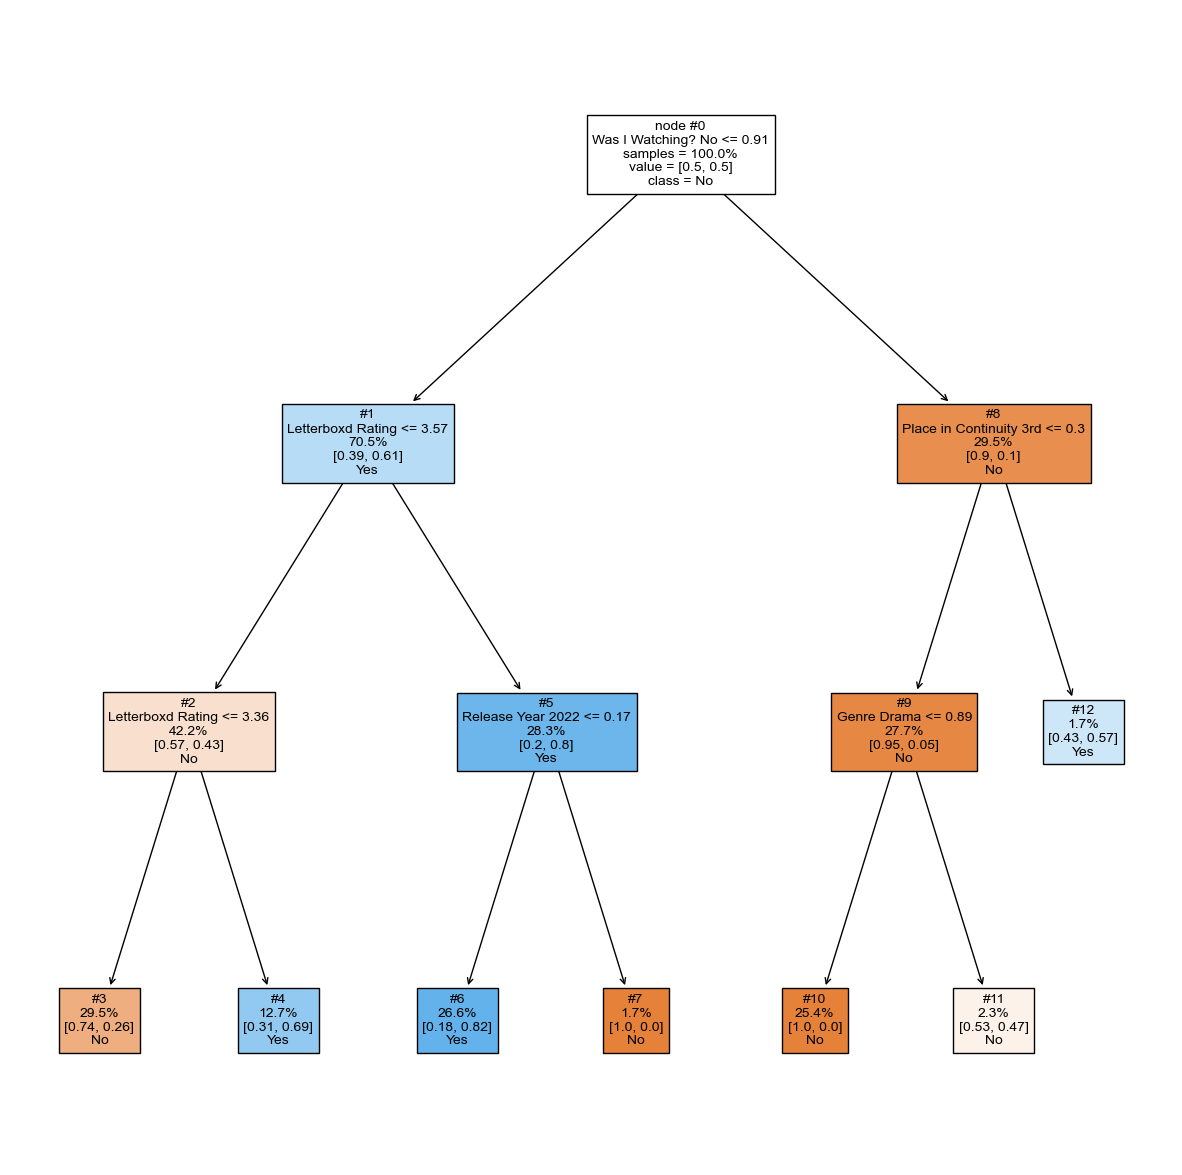

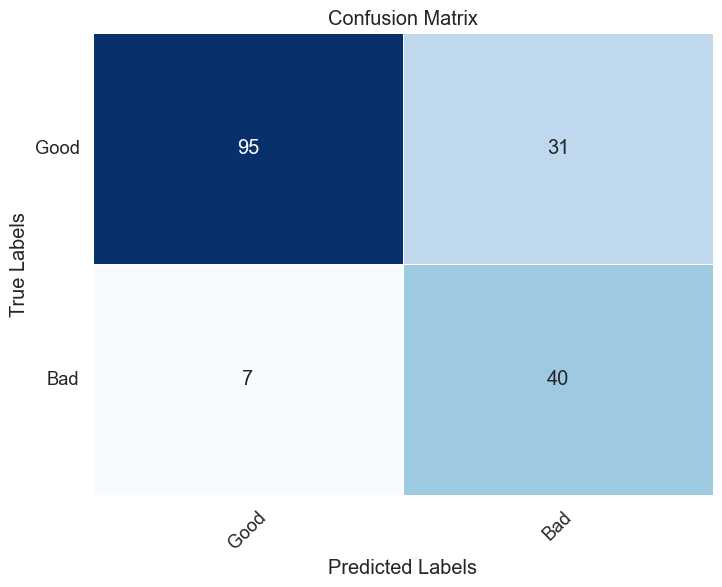

In [25]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define function to train the model
def train_model(d=3, cw='balanced', c='gini', s='random', msl=3):
    # Instantiate the Decision Tree classifier
    clf = DecisionTreeClassifier(max_depth=d,
                                 class_weight=cw,
                                 criterion=c,
                                 splitter=s,
                                 min_samples_leaf=msl)

    # Train the classifier
    clf.fit(x, y)

    # Plot the decision tree
    plt.figure(figsize=(15, 15))
    plot_tree(clf, feature_names=feature_cols, class_names=['No', 'Yes'], filled=True, precision=2, node_ids=True, fontsize=10, label='root', proportion=True, impurity=False)

    # Predict on the test set
    prediction = clf.predict(x)

    # Print classification report
    print(metrics.classification_report(y, prediction))
    
    # Predict probabilities
    probabilities = clf.predict_proba(x)[:, 1]

    return clf, probabilities

# Define function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, classes):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=np.flip(classes), yticklabels=np.flip(classes), linewidths=.5)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Train the model
trained_model, probabilities = train_model()

# Plot confusion matrix
classes = ['Bad', 'Good']
conf_matrix = metrics.confusion_matrix(y, trained_model.predict(x))
plot_confusion_matrix(conf_matrix, classes)

In [26]:
# Find the index of the movie with the highest predicted probability of being perfect
perfect_movie_index = np.argmax(probabilities)

# Extract details of the movie with the highest predicted probability
perfect_movie_details = movie2.iloc[perfect_movie_index]

# Drop the target columns from the perfect movie details
perfect_movie_details = perfect_movie_details.drop(['Target No', 'Target Yes'])

# Define a function to round float values to two decimal places
def round_float(x):
    if isinstance(x, float):
        return round(x, 2)
    else:
        return x

# Apply the rounding function to the perfect movie details
rounded_details = perfect_movie_details.apply(round_float)

# Print the rounded details of the perfect movie
print("The Perfect Movie Would Have These Stats:")
print(rounded_details)

The Perfect Movie Would Have These Stats:
Runtime                                                    106
Real Budget                                            3300000
Real Box Office                                       49000000
Real Profit                                           45700000
Inflated Budget                                        4244598
Inflated Box Office                                   63025857
Inflated Profit                                       58781259
ROI                                                       14.8
RT Top Critics Rating                                       94
RT Top Critics Score                                         8
RT All Critics Rating                                       94
RT All Critics Score                                         8
RT All Audience Rating                                      94
RT All Audience Score                                        4
MC Critics Score                                            89
MC User Score